# Exploring SCP alternatives

In [1]:
using Distributions, JuMP, Gurobi, Plots, ProgressMeter, StatsBase
gurobi_env = Gurobi.Env();

Academic license - for non-commercial use only - expires 2021-11-06


In [2]:
function piecewise_linear(x,cuts)
    #cut esta dado por [valor en nodo, pendiente, nodo]
    return maximum([cut[1]+cut[2]*(x-cut[3]) for cut in cuts])
end

V(x,q,θ) = q*(θ-x)^2/(2*θ)

V (generic function with 1 method)

In [3]:
p = 1.0 #day ahead price
q = 2.0 #same day price
θ = 100.0

#condicion inicial de stock
stock_ini=0.0;

## Classic Stochastic Cutting Plane

In [58]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0;0.0]];

#aca guardo solo los multiplicadores (para ver lo que pasa)
duals = [0.0];

#estados explorados
states = [0.0];

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);

#condicion inicial de stock
stock_ini=0.0;

#inicializo la animacion para ir viendo los cortes paso a paso
anim=Animation()

@showprogress 1 "Computing..." for l=1:500
    
    #Forward Step (IDEM SDDP)
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u0>=0);
    @variable(model,x0>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
    end

    fix_x = @constraint(model,x0.==stock_ini);

    @objective(model,Min,p*u0+z);

    optimize!(model)

    x1_value=value.(u0)+value.(x0);

    #guardo el estado explorado
    push!(states, x1_value)
    
    #Sorteo el ruido del paso
    w=rand(DiscreteUniform(0,100));
    
    #lo agrego a los observados
    push!(noises,w)

    local_cuts = [];

    #resuelvo para cada ruido observado
    for k=1:length(noises)

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u1>=0);
        fix_x = @constraint(model,x1_value-noises[k]+u1.>=0);

        @objective(model,Min,q*u1);

        optimize!(model)

        beta = objective_value(model);
        lambda = -dual.(fix_x)
        
        #guardo el lambda
        push!(duals,lambda);
        
        push!(local_cuts,[beta;lambda;x1_value])

    end

    #Apago los cortes anteriores
    for i=1:length(cuts)
        cuts[i][1] = (l-1)/l*cuts[i][1];
        cuts[i][2] = (l-1)/l*cuts[i][2];
    end
    
    #construyo el nuevo corte y lo agrego
    new_cut = mean(local_cuts);
    push!(cuts,new_cut);
        
    #Grafico para la animacion
    x=(0:100)
    pl=plot(;xlabel="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,p*x+V.(x,q,θ),lw=2)
    plot!(pl,x,p*x+piecewise_linear.(x,Ref(cuts)),lw=2)
    plot!(pl,x,p*x+piecewise_linear.(x,Ref([cuts[end]])),ls=:dash)
    frame(anim)

end

Computing...100%|███████████████████████████████████████| Time: 0:02:14


┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp2.gif
└ @ Plots /home/andres/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp2.gif")
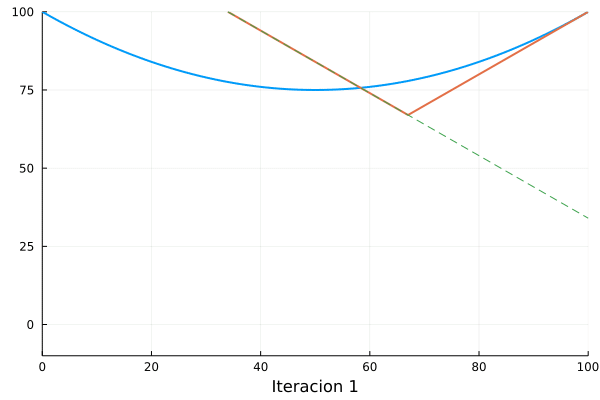

In [59]:
gif(anim,"tmp2.gif",fps=10)

In [60]:
cuts

501-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [0.26800000000000024, -0.004000000000000004, 0.0]
 [0.0, -0.004000000000000004, 67.0]
 [0.032000000000000035, -0.008000000000000009, 67.0]
 [0.07200000000000002, -0.008000000000000009, 71.0]
 [0.06400000000000007, -0.008000000000000009, 80.0]
 [1.6800000000000015, -0.024000000000000004, 0.0]
 [0.29599999999999976, -0.015999999999999983, 60.99999999999999]
 [0.15199999999999986, -0.012000000000000002, 71.00000000000001]
 [0.7559999999999999, -0.031999999999999966, 51.0]
 [0.27680000000000055, -0.01600000000000001, 69.2]
 [0.4179999999999993, -0.024000000000000004, 62.75]
 [0.408, -0.024000000000000004, 67.49999999999999]
 ⋮
 [23.192999999981105, -0.9319999999999997, 47.75000000002061]
 [29.297142857161962, -1.04, 41.714285714267746]
 [25.235000000001797, -0.984, 45.874999999997684]
 [20.02461538462881, -0.868, 51.538461538446356]
 [22.82731034483338, -0.92, 48.413793103441996]
 [30.129714285697343, -1.0519999999999998, 41.1428571428

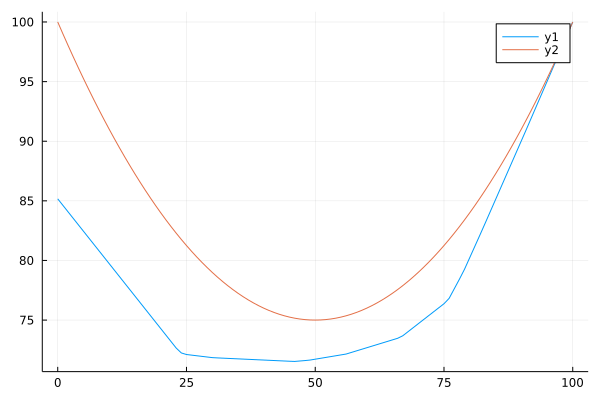

In [61]:
xx=(0:100)
plot(xx,p*xx+piecewise_linear.(xx,Ref(cuts)))
plot!(xx,p*xx+V.(xx,q,θ))

In [62]:
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
@variable(model,u0>=0);
@variable(model,x0>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
end

fix_x = @constraint(model,x0.==stock_ini);

@objective(model,Min,p*u0+z);

optimize!(model)

x1_value=value.(u0)+value.(x0);
println("Stock day ahead: $x1_value.")
println("Costo estimado: $(objective_value(model)).")


Stock day ahead: 45.92857142857347.
Costo estimado: 71.5294285714286.


## Alternativa

En lugar de apagar todos los hiperplanos, solo corrijo los locales promediando con el nuevo.

In [9]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0;0.0]];

#aca guardo solo los multiplicadores (para ver lo que pasa)
duals = [0.0];

#estados explorados
states = [0.0];

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);

#condicion inicial de stock
stock_ini=0.0;

#inicializo la animacion para ir viendo los cortes paso a paso
anim=Animation()

@showprogress 1 "Computing..." for l=1:200
    
    #Forward Step (IDEM SDDP)
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u0>=0);
    @variable(model,x0>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
    end

    fix_x = @constraint(model,x0.==stock_ini);

    @objective(model,Min,p*u0+z);

    optimize!(model)

    x1_value=value.(u0)+value.(x0);

    #guardo el estado explorado
    push!(states, x1_value)
    
    #Sorteo el ruido del paso
    w=rand(DiscreteUniform(0,100));
    
    #lo agrego a los observados
    push!(noises,w)

    local_cuts = [];

    #resuelvo para cada ruido observado
    for k=1:length(noises)

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u1>=0);
        fix_x = @constraint(model,x1_value-noises[k]+u1.>=0);

        @objective(model,Min,q*u1);

        optimize!(model)

        beta = objective_value(model);
        lambda = -dual.(fix_x)
        
        #guardo el lambda
        push!(duals,lambda);
        
        push!(local_cuts,[beta;lambda;x1_value])

    end
    ##hasta aca solo hicimos SCP
    ## Ahora hay que ver que hacemos con los cortes
    
    #El corte nuevo es bueno, construyamoslo:
    new_cut = mean(local_cuts);

    ##Tengo que encontrar los cortes activos de los anteriores y promediarlos con el nuevo
    
    cut_values = map(c->c[1] + c[2]*(x1_value-c[3]),cuts)
    perm = sortperm(cut_values, rev=true)
    if(l>=2)
        max_cuts = cuts[perm[1:2]]

        c1 = max_cuts[1]*(l-1)/l + 1/l*new_cut
        c2 = max_cuts[2]*(l-1)/l + 1/l*new_cut

        ##cambio los activos por los promediados
        cuts[perm[1]] = c1
        cuts[perm[2]] = c2
    end
    
    #agrego el nuevo
    push!(cuts,new_cut);
        
    #Grafico para la animacion
    x=(0:100)
    pl=plot(;xlabel="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,V.(x,q,θ),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref(cuts)),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref([cuts[end]])),ls=:dash)
    frame(anim)

end

Computing...100%|███████████████████████████████████████| Time: 0:00:18


┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp2.gif
└ @ Plots /home/andres/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp2.gif")
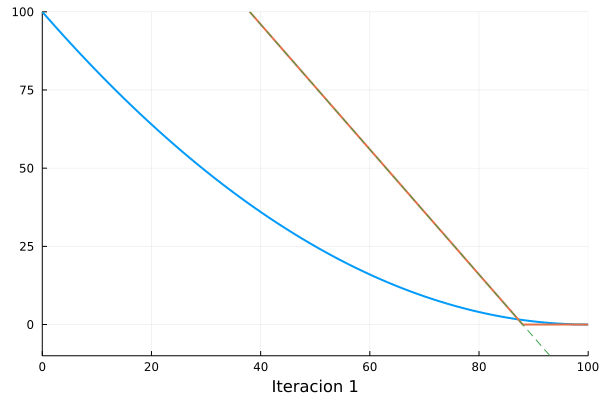

In [10]:
gif(anim,"tmp2.gif",fps=10)

In [11]:
cuts

201-element Vector{Vector{Float64}}:
 [0.0, -0.3333333333333333, 73.33333333333333]
 [49.29380239931873, -1.047008547008547, 58.52476975039851]
 [51.55229683773727, -1.5697382974168694, 38.06912273185759]
 [0.0, -0.0, 107.27048855626099]
 [0.0, -0.0, 107.98089672964205]
 [87.6, -2.0, 0.0]
 [0.0, -0.0, 123.12]
 [96.0, -2.0, 0.0]
 [0.0, -0.0, 119.24571428571427]
 [90.22222222222223, -2.0, 0.0]
 [0.0, -0.0, 116.02088183421515]
 [81.71492978793934, -2.0, 2.5061714696666955]
 [0.0, -0.0, 113.12999269088708]
 ⋮
 [0.0, -0.0, 105.60538102158498]
 [0.0, -0.0, 105.60538102158498]
 [0.0, -0.0, 105.60538102158499]
 [0.0, -0.0, 105.60538102158499]
 [0.0, -0.0, 105.60538102158499]
 [0.0, -0.0, 105.60538102158499]
 [0.0, -0.0, 105.60538102158499]
 [0.0, -0.0, 105.60538102158499]
 [0.0, -0.0, 105.60538102158499]
 [0.0, -0.0, 105.60538102158499]
 [0.0, -0.0, 105.605381021585]
 [0.0, -0.0, 105.605381021585]

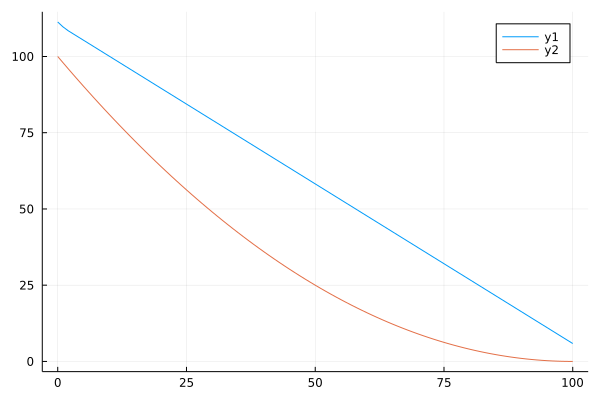

In [12]:
xx=(0:100)
plot(xx,piecewise_linear.(xx,Ref(cuts)))
plot!(xx,V.(xx,q,θ))

In [13]:
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
@variable(model,u0>=0);
@variable(model,x0>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
end

fix_x = @constraint(model,x0.==stock_ini);

@objective(model,Min,p*u0+z);

optimize!(model)

x1_value=value.(u0)+value.(x0);
println("Stock day ahead: $x1_value.")
println("Costo estimado: $(objective_value(model)).")


Stock day ahead: 105.60538102158458.
Costo estimado: 105.60538102158458.


## Alternativa 2

* Busco los hiperplanos activos
* Recalculo el costo y lambda para el ruido nuevo y el x que genero esos dos hiperplanos
* promedio el hiperplano anterior con valores nuevos por k-1/k

In [63]:
p = 1.0 #day ahead price
q = 2.0 #same day price
θ = 100.0

#array de vectores de cuts. Arranca en la lower bound

cuts = [[0.0;0.0;100.0]];

#aca guardo solo los multiplicadores (para ver lo que pasa)
duals = [0.0];

#estados explorados
states = [];

visits = [1];

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);

#condicion inicial de stock
stock_ini=0.0;

#inicializo la animacion para ir viendo los cortes paso a paso
anim=Animation()

@showprogress 1 "Computing..." for l=1:200
    
    #Forward Step (IDEM SDDP)
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u0>=0);
    @variable(model,x0>=0);
    @variable(model,z);
    
    cut_constraints = [];
    for i=1:length(cuts)
        cut=cuts[i]
        cutc = @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
        push!(cut_constraints,cutc);
    end

    fix_x = @constraint(model,x0.==stock_ini);

    @objective(model,Min,p*u0+z);

    optimize!(model)

    x1_value=value.(u0)+value.(x0);

    #guardo el estado explorado
    push!(states, x1_value)
    
    #Sorteo el ruido del paso
    w=rand(DiscreteUniform(0,100));
    
    #lo agrego a los observados
    push!(noises,w)

    local_cuts = [];

    #resuelvo para cada ruido observado
    for k=1:length(noises)

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u1>=0);
        fix_x = @constraint(model,x1_value-noises[k]+u1.>=0);

        @objective(model,Min,q*u1);

        optimize!(model)

        beta = objective_value(model);
        lambda = -dual.(fix_x)
        
        #guardo el lambda
        push!(duals,lambda);
        
        push!(local_cuts,[beta;lambda;x1_value])

    end
    ##hasta aca solo hicimos SCP
    ## Ahora hay que ver que hacemos con los cortes
    
    #El corte nuevo es bueno, construyamoslo:
    new_cut = mean(local_cuts);

    ##Tengo que encontrar los cortes activos de los anteriores recalcular con el nuevo ruido
    active_cuts = findall(dual.(cut_constraints).>0)

    for j=1:length(active_cuts)
    
        cut_viejo = cuts[active_cuts[j]]
        x_viejo = cut_viejo[3]
        visits[active_cuts[j]] = visits[active_cuts[j]]+1; #agrego que le puse un ruido mas
        idx = visits[active_cuts[j]]-1;
        #resuelvo para el x del corte 1 y el ruido nuevo
        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
        @variable(model,u1>=0);
        fix_x = @constraint(model,x_viejo-noises[end]+u1.>=0);
        @objective(model,Min,q*u1);
        optimize!(model)
        beta = objective_value(model);
        lambda = -dual.(fix_x)
        
        
        c1 = cut_viejo*(idx-1)/idx + 1/idx*[beta;lambda;x_viejo]
        cuts[active_cuts[j]] = c1
    end    
    
    #agrego el nuevo
    push!(cuts,new_cut);
    push!(visits, length(noises))
    
    #Grafico para la animacion
    x=(0:100)
    pl=plot(;xlabel="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,p*x+V.(x,q,θ),lw=2)
    plot!(pl,x,p*x+piecewise_linear.(x,Ref(cuts)),lw=2)
    plot!(pl,x,p*x+piecewise_linear.(x,Ref([cuts[end]])),ls=:dash)
    frame(anim)

end

Computing...100%|███████████████████████████████████████| Time: 0:00:28


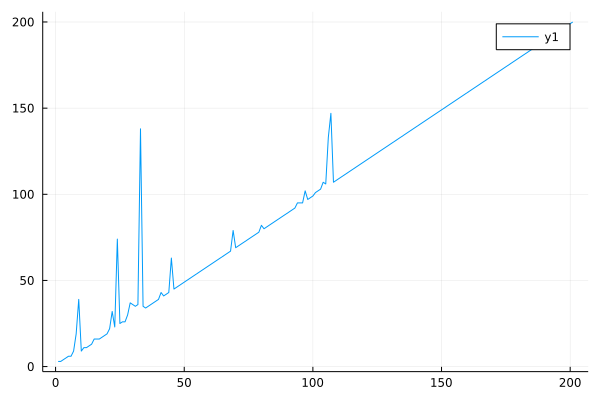

In [64]:
plot(visits)

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp2.gif
└ @ Plots /home/andres/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp2.gif")
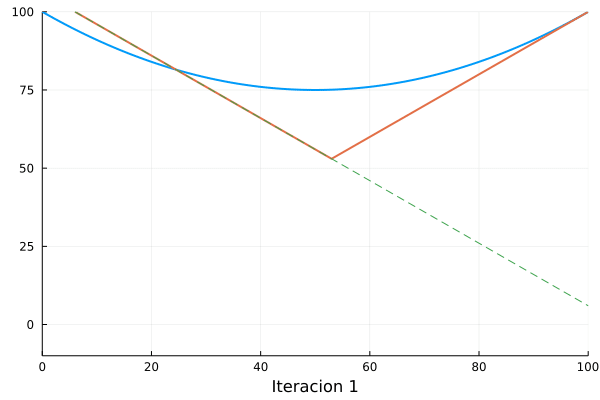

In [65]:
gif(anim,"tmp2.gif",fps=10)

In [67]:
cuts

201-element Vector{Vector{Float64}}:
 [0.0, 0.0, 100.0]
 [61.0, -2.0, 0.0]
 [0.0, -0.3333333333333333, 53.0]
 [0.0, -0.3333333333333333, 53.0]
 [15.95, -1.3, 27.5]
 [5.4399999999999995, -0.64, 37.0]
 [15.272727272727266, -0.875, 34.21212121212122]
 [35.8920634920635, -1.3650793650793647, 33.8]
 [21.28846153846153, -0.9342105263157895, 50.84615384615387]
 [10.962962962962965, -0.4444444444444444, 39.33333333333332]
 [25.306153846153848, -0.74, 38.153846153846146]
 [19.65609584214237, -0.7272727272727273, 39.47286821705425]
 [20.342293906810063, -0.8333333333333334, 39.98924731182792]
 ⋮
 [38.543155164839945, -1.3015873015873016, 32.40383607254169]
 [37.59645195386905, -1.2947368421052632, 32.97835011693041]
 [36.90706323141269, -1.2670157068062826, 33.52376414380244]
 [35.45342555744617, -1.2291666666666667, 34.53789107190822]
 [34.68957126172072, -1.1709844559585492, 35.01288825879602]
 [35.369885637442245, -1.2268041237113403, 34.841353724101545]
 [35.63044203784479, -1.23076923076923

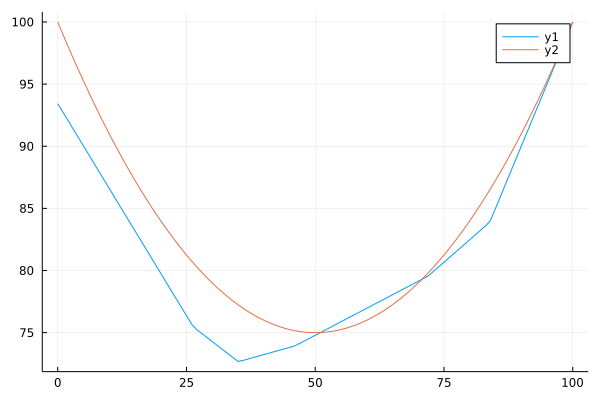

In [68]:
xx=(0:100)
plot(xx,p*xx+piecewise_linear.(xx,Ref(cuts)))
plot!(xx,p*xx+V.(xx,q,θ))

In [69]:
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
@variable(model,u0>=0);
@variable(model,x0>=0);
@variable(model,z);

dual_results=[];

for i=1:length(cuts)
    cut=cuts[i]
    dual_c = @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
    push!(dual_results,dual_c)
end

fix_x = @constraint(model,x0.==stock_ini);

@objective(model,Min,p*u0+z);

optimize!(model)

x1_value=value.(u0)+value.(x0);
println("Stock day ahead: $x1_value.")
println("Costo estimado: $(objective_value(model)).")


Stock day ahead: 35.07794074116118.
Costo estimado: 72.65961445665879.


In [49]:
findall(dual.(dual_results).>0)

2-element Vector{Int64}:
  99
 151

In [50]:
cuts[15]

3-element Vector{Float64}:
  7.820718160682039
 -0.7142857142857143
 68.65099457504515

In [42]:
cuts[16]

3-element Vector{Float64}:
  5.033333333333333
 -0.6666666666666666
 85.25